In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

In [2]:
!cp -r /content/drive/MyDrive/ML_PROJECTS/Competitions/Loan_Payback_Prediction/dataset.zip /content/

In [3]:
!unzip /content/dataset.zip

Archive:  /content/dataset.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
train_df = pd.read_csv('/content/train.csv')
train_df.sample(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
351416,351416,25122.69,0.086,694,3452.02,12.37,Female,Single,Bachelor's,Student,Debt consolidation,C2,1.0
164487,164487,56529.63,0.123,651,14465.63,11.43,Male,Single,Bachelor's,Employed,Debt consolidation,D3,1.0
441531,441531,27896.20,0.098,655,20870.21,11.74,Male,Married,Bachelor's,Employed,Home,D3,0.0
442838,442838,104816.91,0.050,653,26334.56,12.55,Male,Married,Bachelor's,Employed,Debt consolidation,D1,1.0
343165,343165,32579.34,0.020,765,12740.25,12.27,Male,Married,Master's,Employed,Debt consolidation,B3,1.0


In [5]:
train_df.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [7]:
train_df.isna().sum()

,0
id,0
annual_income,0
debt_to_income_ratio,0
credit_score,0
loan_amount,0
interest_rate,0
gender,0
marital_status,0
education_level,0
employment_status,0


In [8]:
len(train_df), train_df.shape

(593994, (593994, 13))

In [9]:
train_df.dtypes

,0
id,int64
annual_income,float64
debt_to_income_ratio,float64
credit_score,int64
loan_amount,float64
interest_rate,float64
gender,object
marital_status,object
education_level,object
employment_status,object


<Axes: xlabel='loan_paid_back'>

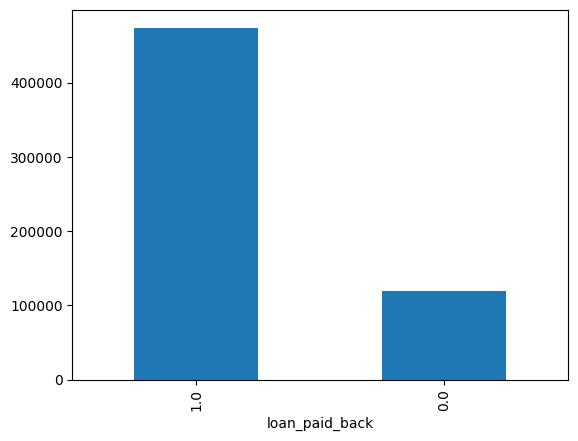

In [10]:
train_df['loan_paid_back'].value_counts().plot.bar()

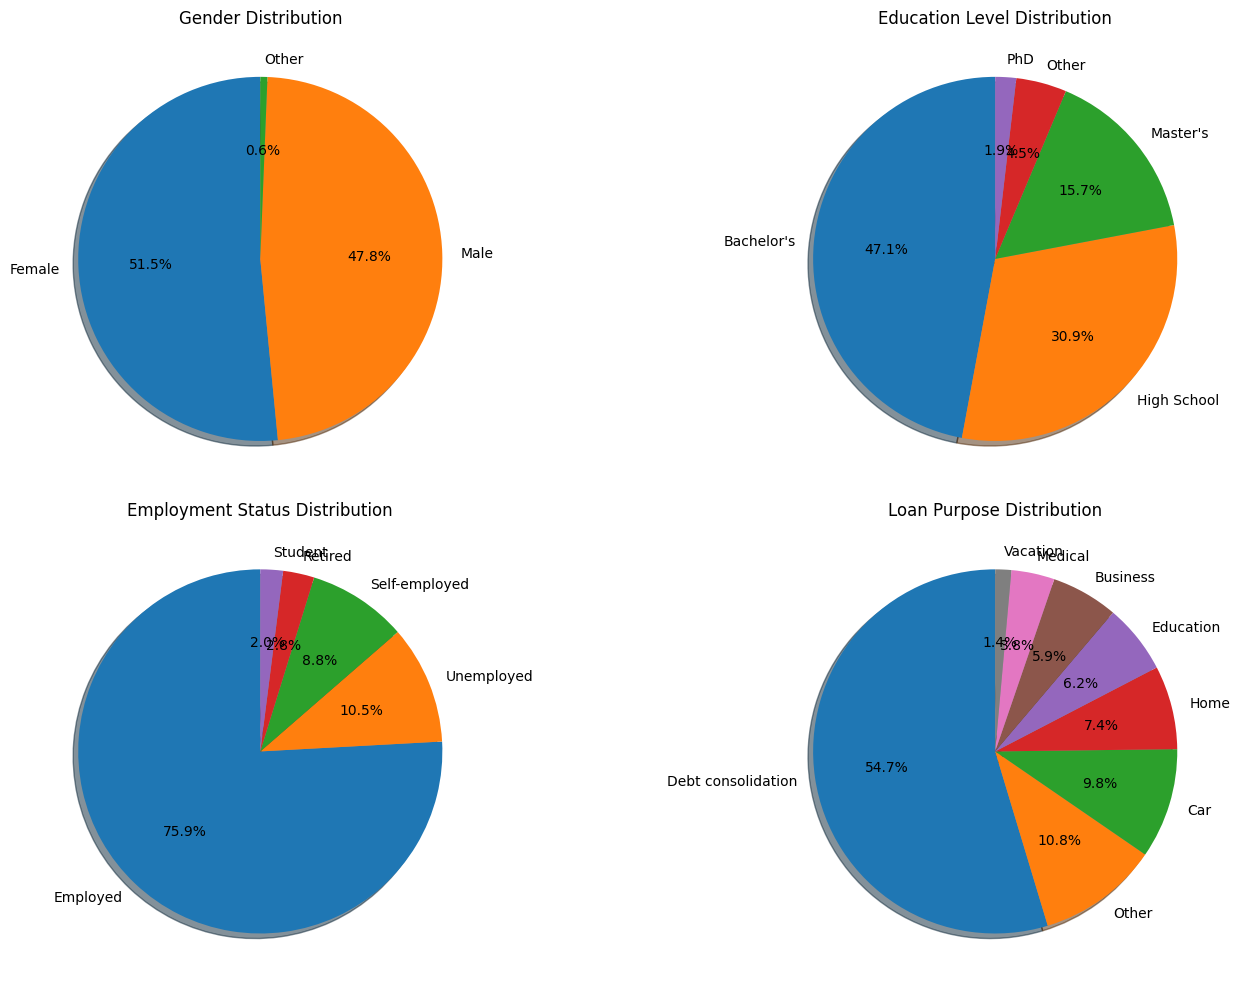

In [11]:
# Categorical columns
cols = ['gender', 'education_level',
        'employment_status', 'loan_purpose']

# Create 2x3 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Flatten axes array for easy looping
axes = axes.flatten()

# Loop through each categorical column
for i, col in enumerate(cols):
    train_df[col].value_counts().plot.pie(
        ax=axes[i],
        autopct='%1.1f%%',
        startangle=90,
        shadow=True
    )
    axes[i].set_title(f"{col.replace('_', ' ').title()} Distribution")
    axes[i].set_ylabel("")  # Hide y-axis label

# Remove any empty subplot (if less than 6)
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


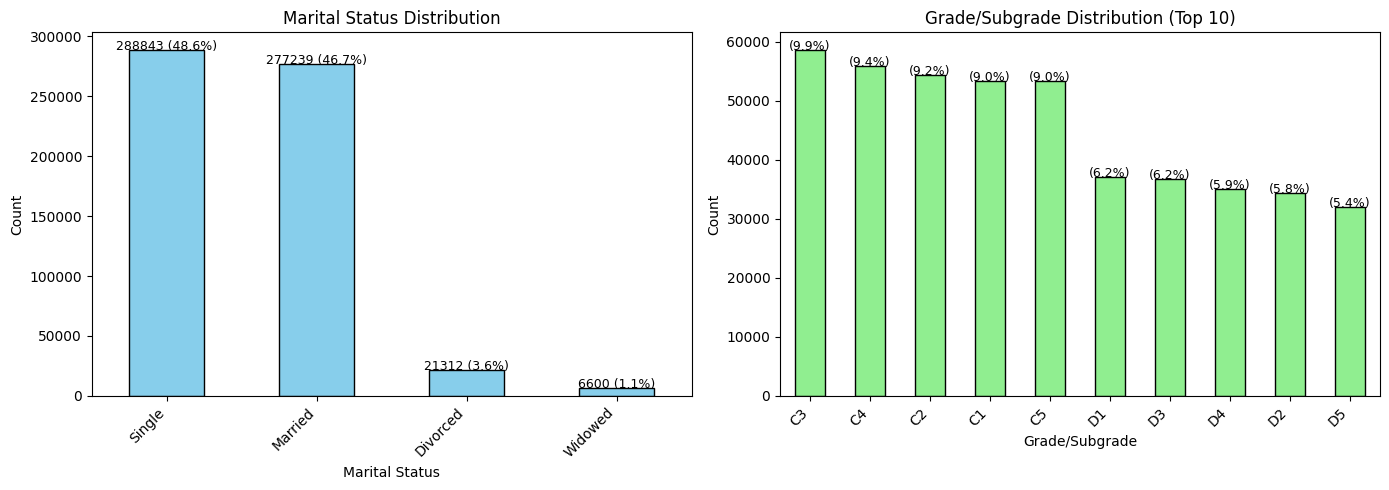

In [12]:
import matplotlib.pyplot as plt

# Prepare data
marital_counts = train_df['marital_status'].value_counts()
marital_perc = train_df['marital_status'].value_counts(normalize=True) * 100

grade_counts = train_df['grade_subgrade'].value_counts().head(10)  # top 10 for clarity
grade_perc = train_df['grade_subgrade'].value_counts(normalize=True).head(10) * 100

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Marital Status ---
bars1 = marital_counts.plot.bar(ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title("Marital Status Distribution")
axes[0].set_xlabel("Marital Status")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
for i, (count, pct) in enumerate(zip(marital_counts.values, marital_perc.values)):
    axes[0].text(i, count + 0.5, f'{count} ({pct:.1f}%)', ha='center', fontsize=9)

# --- Grade/Subgrade ---
bars2 = grade_counts.plot.bar(ax=axes[1], color='lightgreen', edgecolor='black')
axes[1].set_title("Grade/Subgrade Distribution (Top 10)")
axes[1].set_xlabel("Grade/Subgrade")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for i, (count, pct) in enumerate(zip(grade_counts.values, grade_perc.values)):
    axes[1].text(i, count + 0.5, f'({pct:.1f}%)', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


## Feature Engineering

In [13]:
# since id is not going to play role in the payback of the loan, we can drop it.
train_df.drop('id', axis=1, inplace=True)
train_df.sample(1)

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
50746,135400.12,0.141,626,14490.44,12.56,Male,Married,High School,Employed,Debt consolidation,D3,1.0


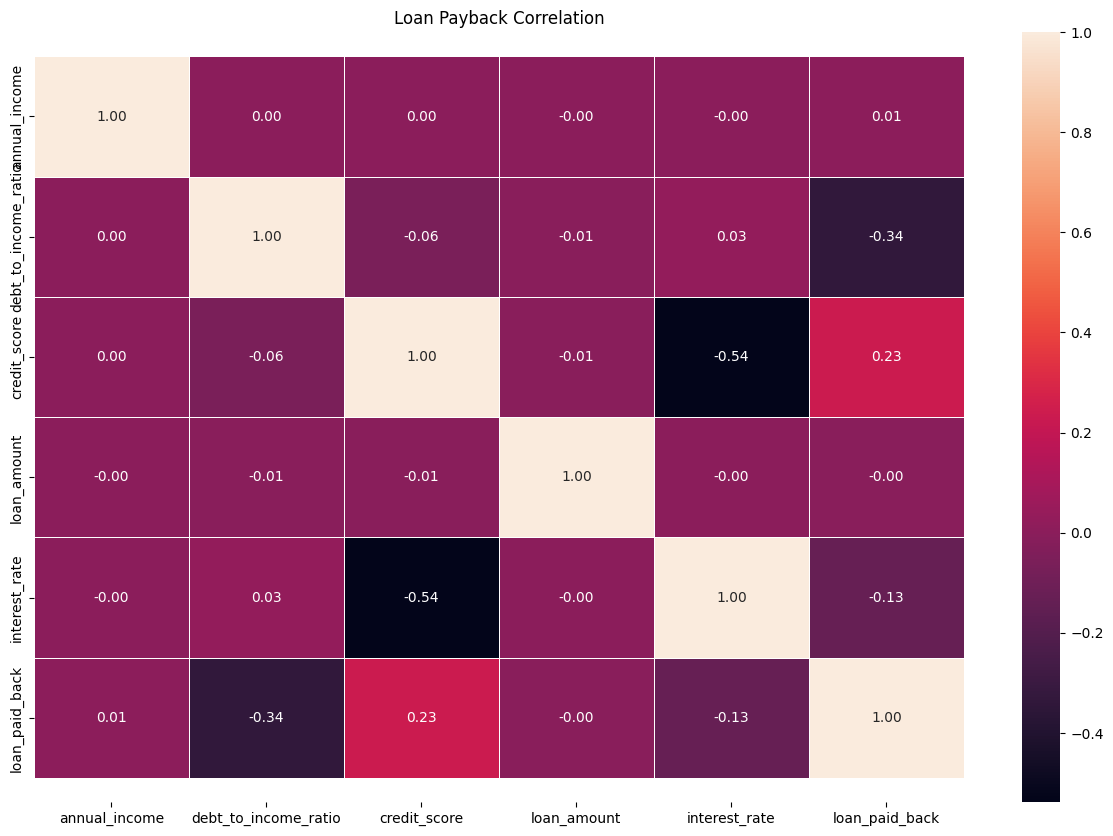

In [14]:
# Compute correlation matrix
corr_matrix = train_df.corr(numeric_only=True)

# Plot heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
    cmap="rocket",
    ax=ax
)

# Fix y-axis cut-off issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.2, top - 0.2)

plt.title("Loan Payback Correlation", fontsize=12)
plt.show()

# Calculating Risk base on different Criteria


In [15]:
biggest_loan_amount = train_df['loan_amount']. max()
print(f"The biggest loan amount is: {biggest_loan_amount}")
Lowest_loan_amount = train_df['loan_amount']. min()
print(f"The Lowest loan amount is: {Lowest_loan_amount}")

The biggest loan amount is: 48959.95
The Lowest loan amount is: 500.09


In [16]:
biggest_income_amount = train_df['annual_income']. max()
print(f"The biggest income amount is: {biggest_income_amount}")
Lowest_income_amount = train_df['annual_income']. min()
print(f"The Lowest income amount is: {Lowest_income_amount}")

The biggest income amount is: 393381.74
The Lowest income amount is: 6002.43


In [17]:
train_df['loan_amount_group'] = pd.qcut(train_df['loan_amount'], q=5, labels=[f'Loan_group{i}' for i in range(1, 6)]).astype(object)
train_df['annual_income_group'] = pd.qcut(train_df['annual_income'], q=5, labels=['Low', 'Lower-Middle', 'Moderate', 'Upper-Middle', 'High']).astype(object)
train_df.sample(5)

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,loan_amount_group,annual_income_group
175142,28500.02,0.147,671,12588.74,12.52,Male,Single,High School,Employed,Car,C2,1.0,Loan_group2,Lower-Middle
213388,70555.59,0.191,637,19131.38,11.99,Male,Single,Bachelor's,Unemployed,Debt consolidation,D4,0.0,Loan_group4,High
526985,24284.09,0.060,646,5490.62,11.39,Male,Married,Bachelor's,Employed,Debt consolidation,D4,0.0,Loan_group1,Low
567406,283854.89,0.091,701,17581.77,16.53,Male,Married,PhD,Employed,Car,C3,1.0,Loan_group4,High
552572,35681.45,0.071,662,5183.59,13.88,Female,Single,High School,Employed,Debt consolidation,D4,1.0,Loan_group1,Lower-Middle


In [18]:
# Loan Paid According to Education Level
edu_payback = train_df.groupby('education_level')['loan_paid_back'].mean().sort_values(ascending=False)
print(edu_payback)
train_df['edu_payback_rate'] = train_df['education_level'].map(edu_payback)


education_level
PhD            0.830067
High School    0.809698
Other          0.802789
Master's       0.802346
Bachelor's     0.788892
Name: loan_paid_back, dtype: float64


In [19]:
train_df

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,loan_amount_group,annual_income_group,edu_payback_rate
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,Loan_group1,Lower-Middle,0.809698
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,Loan_group1,Low,0.802346
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,Loan_group4,Moderate,0.809698
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,Loan_group1,Moderate,0.809698
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,Loan_group2,Lower-Middle,0.809698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593989,23004.26,0.152,703,20958.37,10.92,Female,Single,High School,Employed,Business,C3,1.0,Loan_group5,Low,0.809698
593990,35289.43,0.105,559,3257.24,14.62,Male,Single,Bachelor's,Employed,Debt consolidation,F5,1.0,Loan_group1,Lower-Middle,0.788892
593991,47112.64,0.072,675,929.27,14.13,Female,Married,Bachelor's,Employed,Debt consolidation,C1,1.0,Loan_group1,Moderate,0.788892
593992,76748.44,0.067,740,16290.40,9.87,Male,Single,Bachelor's,Employed,Debt consolidation,B2,1.0,Loan_group3,High,0.788892


In [20]:
# Loan paid according to gender
gender_payback = train_df.groupby('gender')['loan_paid_back'].mean()
print(gender_payback)

train_df['gender_payback_rate'] = train_df['gender'].map(gender_payback)

gender
Female    0.801708
Male      0.795752
Other     0.795333
Name: loan_paid_back, dtype: float64


In [21]:
# loan paid accoring to Loan purpose
purpose_payback = train_df.groupby('loan_purpose')['loan_paid_back'].mean()
print(purpose_payback)

train_df['purpose_payback_rate'] = train_df['loan_purpose'].map(purpose_payback)

loan_purpose
Business              0.813104
Car                   0.800630
Debt consolidation    0.796911
Education             0.777053
Home                  0.823224
Medical               0.778085
Other                 0.802377
Vacation              0.796071
Name: loan_paid_back, dtype: float64


In [22]:
# loan Paid according to employment status
emp_payback = train_df.groupby('employment_status')['loan_paid_back'].mean()
print(emp_payback)

train_df['emp_payback_rate'] = train_df['employment_status'].map(emp_payback)

employment_status
Employed         0.894145
Retired          0.997204
Self-employed    0.898457
Student          0.263515
Unemployed       0.077619
Name: loan_paid_back, dtype: float64


In [23]:
train_df['dti_group'] = pd.qcut(train_df['debt_to_income_ratio'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']).astype(object)
dti_payback = train_df.groupby('dti_group')['loan_paid_back'].mean()
print(dti_payback)

train_df['dti_payback_rate'] = train_df['dti_group'].map(dti_payback).astype(float)

dti_group
High         0.809157
Low          0.884397
Moderate     0.846118
Very High    0.537779
Very Low     0.913557
Name: loan_paid_back, dtype: float64


In [24]:
## Preprocessing object dtypes
cat_features = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_amount_group', 'annual_income_group', 'dti_group']
cat_transformers = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessing numirical dtypes
num_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'edu_payback_rate', 'gender_payback_rate', 'purpose_payback_rate', 'emp_payback_rate', 'dti_payback_rate']
num_transformers = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformers, cat_features),
        ('num', num_transformers, num_features)
    ]
)

## Spliting data into feature and labels

In [25]:
X = train_df.drop('loan_paid_back', axis=1)
y = train_df['loan_paid_back']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(475195, 118799, 475195, 118799)

## Train model

In [26]:
model1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(random_state=42))
])

model1.fit(X_train, y_train)
score1 = model1.score(X_test, y_test)
score1

0.896943576966136

In [27]:
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

model2.fit(X_train, y_train)
score2 = model2.score(X_test, y_test)
score2

0.9048055960067004

In [28]:
neg_count = y_train.value_counts()[0.0]
pos_count = y_train.value_counts()[1.0]
scale_pos_weight = neg_count / pos_count

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_estimators': 3000,
    'learning_rate': 0.015,
    'max_depth': 8,
    'subsample': 0.75,
    'colsample_bytree': 0.6,
    'gamma': 1,
    'lambda': 2.5,
    'min_child_weight': 25,
    'scale_pos_weight': scale_pos_weight,
    'seed': 42,
    'n_jobs': -1,
    'early_stopping_rounds': 100,
    'verbosity': 1,
    'tree_method': 'hist'
}

In [29]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


model3 = XGBClassifier(**xgb_params)
model3.fit(X_train_processed, y_train, eval_set=[(X_test_processed, y_test)])
score3 = model3.score(X_test_processed, y_test)
score3

[0]	validation_0-logloss:0.68524
[1]	validation_0-logloss:0.67755
[2]	validation_0-logloss:0.67067
[3]	validation_0-logloss:0.66415
[4]	validation_0-logloss:0.65809
[5]	validation_0-logloss:0.65168
[6]	validation_0-logloss:0.64892
[7]	validation_0-logloss:0.64262
[8]	validation_0-logloss:0.63705
[9]	validation_0-logloss:0.63453
[10]	validation_0-logloss:0.62867
[11]	validation_0-logloss:0.62295
[12]	validation_0-logloss:0.61741
[13]	validation_0-logloss:0.61214
[14]	validation_0-logloss:0.60952
[15]	validation_0-logloss:0.60419
[16]	validation_0-logloss:0.59874
[17]	validation_0-logloss:0.59367
[18]	validation_0-logloss:0.58836
[19]	validation_0-logloss:0.58363
[20]	validation_0-logloss:0.57857
[21]	validation_0-logloss:0.57363
[22]	validation_0-logloss:0.56892
[23]	validation_0-logloss:0.56430
[24]	validation_0-logloss:0.55970
[25]	validation_0-logloss:0.55553
[26]	validation_0-logloss:0.55347
[27]	validation_0-logloss:0.54964
[28]	validation_0-logloss:0.54538
[29]	validation_0-loglos

0.8697716310743356

In [30]:
test_df = pd.read_csv('/content/test.csv')
test_df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1


In [31]:
id = test_df['id'].copy()
id

,id
0,593994
1,593995
2,593996
3,593997
4,593998
...,...
254564,848558
254565,848559
254566,848560
254567,848561


In [34]:
# Apply the same feature engineering steps to test_df
test_df['loan_amount_group'] = pd.qcut(test_df['loan_amount'], q=5, labels=[f'Loan_group{i}' for i in range(1, 6)]).astype(object)
test_df['annual_income_group'] = pd.qcut(test_df['annual_income'], q=5, labels=['Low', 'Lower-Middle', 'Moderate', 'Upper-Middle', 'High']).astype(object)

# Map payback rates using the rates learned from train_df
test_df['edu_payback_rate'] = test_df['education_level'].map(edu_payback)
test_df['gender_payback_rate'] = test_df['gender'].map(gender_payback)
test_df['purpose_payback_rate'] = test_df['loan_purpose'].map(purpose_payback)
test_df['emp_payback_rate'] = test_df['employment_status'].map(emp_payback)

# Create dti_group and dti_payback_rate for test_df
test_df['dti_group'] = pd.qcut(test_df['debt_to_income_ratio'], q=5, labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High']).astype(object)
test_df['dti_payback_rate'] = test_df['dti_group'].map(dti_payback).astype(float)

# Now, preprocess the test_df with the engineered features
test_df_processed = preprocessor.transform(test_df.drop('id', axis=1))
result = model3.predict(test_df_processed)

In [35]:
output = pd.DataFrame({"id":id,"loan_paid_back":result})
output.to_csv("/content/drive/MyDrive/ML_PROJECTS/Competitions/Loan_Payback_Prediction/submission.csv",index=False)
df=pd.read_csv('/content/drive/MyDrive/ML_PROJECTS/Competitions/Loan_Payback_Prediction/submission.csv')
df.head()

,id,loan_paid_back
0,593994,1
1,593995,1
2,593996,0
3,593997,1
4,593998,1
